# Finding Geographic Locations of Headlines

## Adding Latitude and Longitude Coordinates

__Objective__: Find the geographic location of each headline in latitude and longitude coordinates from the city/country names. We will use these coordinates to perform clustering of geographically similar headlines in the next part.

__Workflow__:
1.	Load in the Pandas DataFrame with headline, countries, and cities.
    -	If a headline contains multiple cities/countries, decide which single one to keep.
2.	For each city/country, match the name to the latitude and longitude in geonamescache.
    -	You can use the function gc.get_cities_by_names(“city_name”).
    -	Some cities will return multiple matches with the previous function in different countries. You’ll have to decide which city to keep based on a heuristic (rule of thumb).
    -	If you have trouble, work with a single problematic city until you figure it out, then write a function to apply on all headlines.
3.	Add longitude and latitude coordinates to your DataFrame for each headline.
    -	It will be helpful to get the countrycode of each headline at this point.
    -	If you were not able to find many countries, think about dropping the column. You also need to decide what to do with headlines that have no coordinates. 
    -	You should end up with over 600 headlines that have geographic coordinates
    
__Deliverable__:

The deliverable is a Jupyter Notebook documenting your work as you add three additional columns to the DataFrame: longitude, latitude, and countrycode. We will use these coordinates to cluster the headlines in the next section. 

## Read Data into a DataFrame

We stored the headline, cities, and countries as a json file that was a list of dictionaries. This can be directly read in a Pandas dataframe.

In [1]:
import pandas as pd
import numpy as np

data = pd.read_json("./data/headline_cities_and_countries.json")
data = data.replace({None: np.nan})
data.head()

,headline,countries,cities
0,Zika Outbreak Hits Miami,NaN,Miami
1,Could Zika Reach New York City?,NaN,New York City
2,First Case of Zika in Miami Beach,NaN,Miami Beach
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife
4,Dallas man comes down with case of Zika,NaN,Dallas


In [2]:
data.iloc[3:5]

,headline,countries,cities
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife
4,Dallas man comes down with case of Zika,NaN,Dallas


We'll rename the columns to singular (since they only have one value each).

In [3]:
data = data.rename(columns=dict(countries="country", cities="city"))
data.tail()

,headline,country,city
645,Rumors about Rabies spreading in Jerusalem hav...,NaN,Jerusalem
646,More Zika patients reported in Indang,NaN,Indang
647,Suva authorities confirmed the spread of Rotav...,NaN,Suva
648,More Zika patients reported in Bella Vista,NaN,Bella Vista
649,Zika Outbreak in Wichita Falls,NaN,Wichita Falls


From a brief look at some of the headlines and cities, our regular expression pattern matching looks to have worked well. As we go through the project, we'll keep an eye out for places it may have failed.

## Investigate the Data

We can start off using the `.describe()` method to understand our data.

In [4]:
data.describe()

,headline,country,city
count,650,15,608
unique,647,10,573
top,Barcelona Struck by Spanish Flu,Malaysia,Miami
freq,2,3,4


It looks like there may be some duplicates in the data since at least one headline is mentioned twice. Let's check for duplicates and then drop any that are duplicated.

In [5]:
data["headline"].value_counts().sort_values().tail()

Princeton Encounters Severe Symptoms of Dengue                    1
More people in Mclean are infected with Hepatitis A every year    1
Spanish Flu Spreading through Madrid                              2
Spanish Flu Outbreak in Lisbon                                    2
Barcelona Struck by Spanish Flu                                   2
Name: headline, dtype: int64

In [6]:
print(f"There were {len(data)} rows before dropping duplicates.")
data = data.drop_duplicates()
print(f"There are {len(data)} rows after dropping duplicates.")

There were 650 rows before dropping duplicates.
There are 647 rows after dropping duplicates.


Another useful method for data investigation is `.info()`

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 647 entries, 0 to 649
Data columns (total 3 columns):
headline    647 non-null object
country     15 non-null object
city        605 non-null object
dtypes: object(3)
memory usage: 20.2+ KB


We can see there are many missing countries (635) and some missing cities (42). The data types look correct at this point.

### Exploratory Plots

Plots are a great way to visualize data. Let's take a look at the distribution of countries and cities.

In [8]:
data['country'].value_counts()

Brazil       3
Malaysia     3
Panama       2
Thailand     1
Vietnam      1
Hong Kong    1
Mexico       1
Belize       1
Guatemala    1
Singapore    1
Name: country, dtype: int64

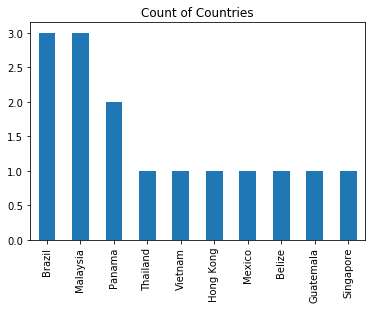

In [13]:
%matplotlib inline

_ = data['country'].value_counts().plot.bar(title='Count of Countries')

We have many more cities, so a bar plot might not be the best graphic.

In [14]:
print(f'There are {data["country"].nunique()} different countries.')
print(f'There are {data["city"].nunique()} different cities.')

There are 10 different countries.
There are 573 different cities.


Let's just look at the 10 most common cities.

In [15]:
data["city"].value_counts().sort_values().tail(10)

Melbourne    2
Bedford      2
Cancun       2
Edinburgh    2
Richmond     2
Hollywood    2
Ibadan       2
Madrid       3
Monroe       4
Miami        4
Name: city, dtype: int64

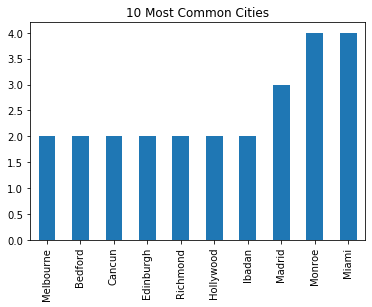

In [16]:
_ = (
    data["city"]
    .value_counts()
    .sort_values()
    .tail(10)
    .plot.bar(title="10 Most Common Cities")
)

We can see that there are no cities that dominate the headlines.

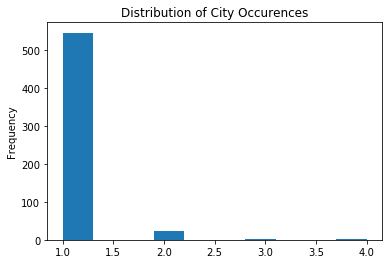

In [17]:
_ = data["city"].value_counts().plot.hist(title="Distribution of City Occurences")

# Add Latitude and Longitude for Each City

We can now add the latitude and longitude for each city in the headlines. We will not add the country locations since there are a limited number of countries.

## Accented Names

For finding the cities, we need to use accented city names. We'll create an accented name column using our mapping from the previous section.

In [18]:
import geonamescache
import unidecode

import json

gc = geonamescache.GeonamesCache()

# Read in the saved unaccented:accented mapping
with open("./data/city_accent_mapping.json", "r") as fin:
    city_accented_mapping = json.loads(fin.read())

# Create a column for accented cities
data["accented_city"] = data["city"].map(city_accented_mapping)
data[data["city"] != data["accented_city"]].head()

,headline,country,city,accented_city
7,Geneve Scientists Battle to Find Cure,NaN,Geneve,Genève
9,Zika Infested Monkeys in Sao Paulo,NaN,Sao Paulo,São Paulo
17,Louisiana Zika cases up to 26,NaN,NaN,NaN
19,Zika infects pregnant woman in Cebu,NaN,NaN,NaN
47,18 new Zika Cases in Bogota,NaN,Bogota,Bogotá


We can see there are several cases where the accented city does not match the original city.

In [19]:
print(gc.get_cities_by_name('São Paulo'))

[{'3448439': {'geonameid': 3448439, 'name': 'São Paulo', 'latitude': -23.5475, 'longitude': -46.63611, 'countrycode': 'BR', 'population': 10021295, 'timezone': 'America/Sao_Paulo', 'admin1code': '27'}}]


In [20]:
print(gc.get_cities_by_name('Sao Paulo'))

[]


We see the importance of using the accented names!

## Handling Duplicate Cities

This is where we'll handle the duplicate cities. Our approach is relatively basic:

__For each city with multiple entries in geonames, we'll choose the city with the greatest population.__ 

This is may occassionally be wrong, but a headline is more likely to mention a larger city (by population).

We can implement this by checking which is the largest entry for each city. Some cities have multiple locations as shown by `Boston`.

In [21]:
city = 'Boston'
gc.get_cities_by_name(city)

[{'2655138': {'geonameid': 2655138,
   'name': 'Boston',
   'latitude': 52.97633,
   'longitude': -0.02664,
   'countrycode': 'GB',
   'population': 41340,
   'timezone': 'Europe/London',
   'admin1code': 'ENG'}},
 {'4930956': {'geonameid': 4930956,
   'name': 'Boston',
   'latitude': 42.35843,
   'longitude': -71.05977,
   'countrycode': 'US',
   'population': 667137,
   'timezone': 'America/New_York',
   'admin1code': 'MA'}}]

In this case we want `Boston` in the United States since it has the larger population. To get the largest city, we sort the matches by the `population` key. 

In [22]:
matches = gc.get_cities_by_name(city)
matches = [{k: v for k, v in list(match.values())[0].items()} for match in matches]
matches = sorted(matches, key=lambda x: x["population"], reverse=True)
matches

[{'geonameid': 4930956,
  'name': 'Boston',
  'latitude': 42.35843,
  'longitude': -71.05977,
  'countrycode': 'US',
  'population': 667137,
  'timezone': 'America/New_York',
  'admin1code': 'MA'},
 {'geonameid': 2655138,
  'name': 'Boston',
  'latitude': 52.97633,
  'longitude': -0.02664,
  'countrycode': 'GB',
  'population': 41340,
  'timezone': 'Europe/London',
  'admin1code': 'ENG'}]

This sorts by the population of the cities descending (largest to smallest). If we take the first city, then we'll have the largest.

## Finding Locations for Cities

Now let's find the locations of all the cities in the headlines. We'll want to be careful to go through the accented city names. If there are multiple matches for a city, we'll take the largest city.

In [23]:
city_locations = []

# Go through all the accented cities
for city in data["accented_city"]:
    # Find matches (if any)
    matches = gc.get_cities_by_name(city)
    if matches:
        # Sort from largest to smallest population
        matches = [
            {k: v for k, v in list(match.values())[0].items()} for match in matches
        ]
        matches = sorted(matches, key=lambda x: x["population"], reverse=True)

        # Find the match with the largest population
        match = matches[0]

        # Record the information
        city_locations.append(
            {
                "name": match["name"],
                "latitude": match["latitude"],
                "longitude": match["longitude"],
                "countrycode": match["countrycode"],
                "pop": match["population"],
            }
        )

city_locations[-5:]

[{'name': 'Jerusalem',
  'latitude': 31.76904,
  'longitude': 35.21633,
  'countrycode': 'IL',
  'pop': 801000},
 {'name': 'Indang',
  'latitude': 14.19528,
  'longitude': 120.87694,
  'countrycode': 'PH',
  'pop': 41159},
 {'name': 'Suva',
  'latitude': -18.14161,
  'longitude': 178.44149,
  'countrycode': 'FJ',
  'pop': 77366},
 {'name': 'Bella Vista',
  'latitude': 18.45539,
  'longitude': -69.9454,
  'countrycode': 'DO',
  'pop': 175683},
 {'name': 'Wichita Falls',
  'latitude': 33.91371,
  'longitude': -98.49339,
  'countrycode': 'US',
  'pop': 104710}]

We can convert this list of dictionaries to a dataframe.

In [24]:
city_locations = pd.DataFrame(city_locations)
city_locations.tail()

,name,latitude,longitude,countrycode,pop
600,Jerusalem,31.76904,35.21633,IL,801000
601,Indang,14.19528,120.87694,PH,41159
602,Suva,-18.14161,178.44149,FJ,77366
603,Bella Vista,18.45539,-69.94540,DO,175683
604,Wichita Falls,33.91371,-98.49339,US,104710


In [25]:
city_locations = city_locations.drop_duplicates()
print(f"We have the locations for {city_locations.shape[0]} unique cities.")

We have the locations for 573 unique cities.


Next let's merge with the headlines on the `accented_city` and `name`.

In [26]:
data = pd.merge(
    data, city_locations, left_on="accented_city", right_on="name", how="left"
)
data.head()

,headline,country,city,accented_city,name,latitude,longitude,countrycode,pop
0,Zika Outbreak Hits Miami,NaN,Miami,Miami,Miami,25.77427,-80.19366,US,441003.0
1,Could Zika Reach New York City?,NaN,New York City,New York City,New York City,40.71427,-74.00597,US,8175133.0
2,First Case of Zika in Miami Beach,NaN,Miami Beach,Miami Beach,Miami Beach,25.79065,-80.13005,US,92312.0
3,"Mystery Virus Spreads in Recife, Brazil",Brazil,Recife,Recife,Recife,-8.05389,-34.88111,BR,1478098.0
4,Dallas man comes down with case of Zika,NaN,Dallas,Dallas,Dallas,32.78306,-96.80667,US,1300092.0


Let's make sure keeping the largest city worked. We can try `Boston` as well as `Rochester`, both of which should be in the United States.

In [27]:
data[data['city'] == 'Boston']

,headline,country,city,accented_city,name,latitude,longitude,countrycode,pop
27,Flu season hits Boston,NaN,Boston,Boston,Boston,42.35843,-71.05977,US,667137.0


In [28]:
data[data['city'] == 'Rochester']

,headline,country,city,accented_city,name,latitude,longitude,countrycode,pop
84,Rochester authorities confirmed the spread of ...,NaN,Rochester,Rochester,Rochester,43.15478,-77.61556,US,209802.0
298,Herpes Keeps Spreading in Rochester,NaN,Rochester,Rochester,Rochester,43.15478,-77.61556,US,209802.0


It looks like our method for finding the largest city worked as expected. For each headline with a city in `geonamescache`, we now have the latitude and longitude.

Due to the limited number of countries found in headlines, we'll stick to only the cities.

## Data Cleaning

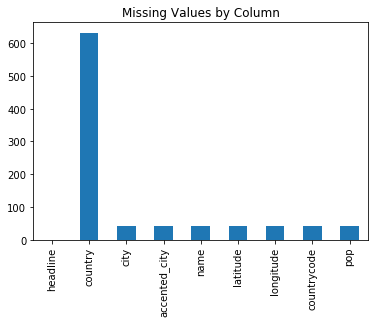

In [29]:
_ = data.isna().sum().plot.bar(title='Missing Values by Column')

We can see there are quite a few missing values in the `country` column. Let's just remove the country since it does not give us much information. 

In [30]:
data = data.drop(columns=['country'])

Let's investigate the headlines where we don't have a `name`. We might be able to figure out more data cleaning steps to take.

In [31]:
pd.options.display.max_colwidth = 100

no_name = data[data["name"].isna()].copy()

print(f"There are {len(no_name)} headlines without a city.")

no_name.tail()

There are 42 headlines without a city.


,headline,city,accented_city,name,latitude,longitude,countrycode,pop
596,Zika arrives in Dangriga,NaN,NaN,NaN,NaN,NaN,NaN,NaN
601,More Patients in Maynard are Getting Diagnosed with Syphilis,NaN,NaN,NaN,NaN,NaN,NaN,NaN
625,Zika case reported in Antioquia,NaN,NaN,NaN,NaN,NaN,NaN,NaN
627,Chikungunya has not Left Pismo Beach,NaN,NaN,NaN,NaN,NaN,NaN,NaN
628,Zika spreads to La Joya,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We should manually check a few of these to make sure we can't find a city for the headline.

In [32]:
city_set = set(city_accented_mapping.keys())

for city in ["Dangriga", "Maynard", "Antioquia", "Pismo Beach", "La Joya"]:
    if city in city_set:
        print("Found ", city)
    else:
        print("Did Not Find City")

Did Not Find City
Did Not Find City
Did Not Find City
Did Not Find City
Did Not Find City


It appears that the 42 headlines without a city name may have a city, but it is not included in `geonamescache`. We'll have to go ahead and remove these cities since they cannot be used.

In [33]:
data = data.dropna(subset=['name'])
data.describe()

,latitude,longitude,pop
count,605.000000,605.000000,6.050000e+02
mean,26.765746,-38.243197,8.904713e+05
std,20.619771,79.480854,1.974091e+06
min,-53.787690,-156.506040,1.338100e+04
25%,16.419040,-90.444300,5.878700e+04
50%,33.749000,-76.496610,1.712140e+05
75%,40.714270,7.095490,6.480340e+05
max,59.938630,179.364510,1.307630e+07


In [34]:
print(f'We have the city locations for {len(data)} cities.')

We have the city locations for 605 cities.


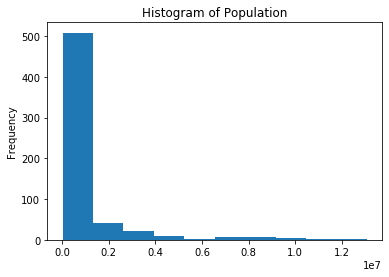

In [32]:
_ = data['pop'].plot.hist(title='Histogram of Population')

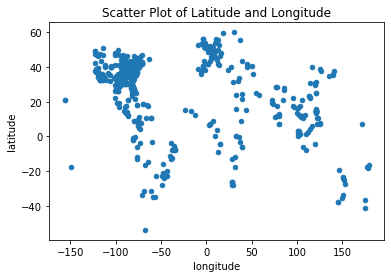

In [33]:
_ = data.plot.scatter(
    x="longitude", y="latitude", title="Scatter Plot of Latitude and Longitude"
)

This looks sort of like a map! We'll have to use a map in the next section.

As a final cleaning step, we can remove the `name` column since it is redundant with city. The final data frame is below.

In [35]:
data = data.drop(columns=['name'])
data.tail()

,headline,city,accented_city,latitude,longitude,countrycode,pop
642,Rumors about Rabies spreading in Jerusalem have been refuted,Jerusalem,Jerusalem,31.76904,35.21633,IL,801000.0
643,More Zika patients reported in Indang,Indang,Indang,14.19528,120.87694,PH,41159.0
644,Suva authorities confirmed the spread of Rotavirus,Suva,Suva,-18.14161,178.44149,FJ,77366.0
645,More Zika patients reported in Bella Vista,Bella Vista,Bella Vista,18.45539,-69.94540,DO,175683.0
646,Zika Outbreak in Wichita Falls,Wichita Falls,Wichita Falls,33.91371,-98.49339,US,104710.0


In [36]:
data[['headline', 'city', 'latitude', 'longitude', 'countrycode']].head(10)

,headline,city,latitude,longitude,countrycode
0,Zika Outbreak Hits Miami,Miami,25.77427,-80.19366,US
1,Could Zika Reach New York City?,New York City,40.71427,-74.00597,US
2,First Case of Zika in Miami Beach,Miami Beach,25.79065,-80.13005,US
3,"Mystery Virus Spreads in Recife, Brazil",Recife,-8.05389,-34.88111,BR
4,Dallas man comes down with case of Zika,Dallas,32.78306,-96.80667,US
5,Trinidad confirms first Zika case,Trinidad,-14.83333,-64.90000,BO
6,Zika Concerns are Spreading in Houston,Houston,29.76328,-95.36327,US
7,Geneve Scientists Battle to Find Cure,Geneve,46.20222,6.14569,CH
8,The CDC in Atlanta is Growing Worried,Atlanta,33.74900,-84.38798,US
9,Zika Infested Monkeys in Sao Paulo,Sao Paulo,-23.54750,-46.63611,BR


This dataframe is the final outcome from this section. We will use it to cluster headlines based on the geographic location in the next section.

## Saving Data

Let's save the final processed dataframe to a csv file for easy input and output with Pandas.

In [37]:
data.to_csv('./data/processed_headlines_locations.csv')

# Summary

In this notebook we:

* Read the parsed headlines into a dataframe
* Found the location of the cities mentioned in the headlines
* Kept the largest city if a city was in geonames multiple times
* Joined the cities to the headlines 
* Cleaned up the final dataframe to only headlines with a location

The end deliverable is a dataframe containing the headline, the city mentioned in the headline, the location of the city, and the population of the city. We can move on to clustering and visualizing the headline locations in the next section!